# How effective is our short-term approach to predicting monthly peaks?

In [306]:
import numpy as np
import pandas as pd
from scipy.stats import norm

In [307]:
# regions: COAST, EAST, FWEST, NCENT, NORTH, SCENT, SOUTH, WEST
REGION = 'COAST'

In [308]:
df = pd.read_csv('data/' + REGION + '.csv', parse_dates=['dates'])
df = df.groupby(df.dates.dt.date).max()
df = df.drop(['tempc', 'dates'], axis=1)
df.head()

,load
dates,
2002-01-01,9679.928958
2002-01-02,10835.067044
2002-01-03,11190.440561
2002-01-04,10605.590872
2002-01-05,8656.972096


In [309]:
ONE_DAY = 0.03
TWO_DAY = 0.05
THREE_DAY = 0.08
med = df['load'].median()

In [310]:
df['one'] = df['load'] + np.random.normal(0, ONE_DAY*med, df.shape[0])
df['two'] = df['load'] + np.random.normal(0, TWO_DAY*med, df.shape[0])
df['three'] = df['load'] + np.random.normal(0, THREE_DAY*med, df.shape[0])
df['two'] = df['two'].shift(-1)
df['three'] = df['three'].shift(-2)

In [311]:
def pl(x):
    return peak_likelihood(hist=x['hist'], tomorrow=x['one'], tomorrow_std=x['one']*ONE_DAY,
                              two_day=x['two'], two_day_std=x['two']*TWO_DAY,
                                three_day=x['three'], three_day_std=x['three']*THREE_DAY)
def peak_likelihood(hist=None, tomorrow=None, tomorrow_std=None, 
                        two_day=None, two_day_std=None, three_day=None, three_day_std=None):
    A = norm(tomorrow, tomorrow_std).cdf(hist)
    B = norm(0, 1).cdf(-(tomorrow - two_day) / ((tomorrow_std**2 + two_day_std**2)**.5))
    C = norm(0, 1).cdf(-(tomorrow - three_day) / ((tomorrow_std**2 + three_day_std**2)**.5))
    return round((1 - A)*(1 - B)*(1 - C)*100, 2)


def highest_so_far(x, df):
    m = df[(df['my'] == x['my']) & (df['day'] < x['day'])]
    return m['load'].max() if m.shape[0] != 0 else 0


def q(r):
    m = df[(df['month'] == r['month']) & (df['year'] < r['year'])].copy()
    return -1 if m.shape[0] == 0 else round(float(m[r['one'] >= m['load']].shape[0]) / m['load'].shape[0] * 100, 2)

In [312]:
df['dates'] = df.index.astype('datetime64[ns]')
df['month'] = df.dates.dt.month
df['year'] = df.dates.dt.year
df['day'] = df.dates.dt.day
df['my'] = df.dates.dt.month.astype(str) + '_' + df.dates.dt.year.astype(str)

df['hist'] = df.apply(lambda x: highest_so_far(x, df), axis=1)

peak_dates = df.groupby('my')['load'].idxmax().tolist()
df['is_peak'] = df.index.map(lambda x: x in peak_dates)

df['likelihood'] = df.apply(pl, axis=1)

df['q'] = df.apply(q, axis=1)
df = df[df['year'] > 2008]

In [313]:
df.head()

,load,one,two,three,dates,month,year,day,my,hist,is_peak,likelihood,q
dates,,,,,,,,,,,,,
2009-01-01,8432.994347,8401.765975,9149.971328,9669.885569,2009-01-01,1,2009,1,1_2009,0.000000,False,0.45,4.61
2009-01-02,9473.169066,9483.483442,9981.928007,8547.998802,2009-01-02,1,2009,2,1_2009,8432.994347,False,17.29,46.08
2009-01-03,9448.893572,9429.482115,8914.516824,11924.324441,2009-01-03,1,2009,3,1_2009,9473.169066,False,0.22,44.70
2009-01-04,8648.723910,8661.186390,11095.022608,9632.359763,2009-01-04,1,2009,4,1_2009,9473.169066,False,0.00,10.60
2009-01-05,11051.920732,11604.480196,9641.435530,11419.249948,2009-01-05,1,2009,5,1_2009,9473.169066,False,57.49,96.77


In [314]:
def F(a, b):
    return a + b

def test(df, l, q, use_and=True):
    if use_and:
        dispatched = df[(df['likelihood'] >= l) & (df['q'] >= q)].shape[0]
    else:
        dispatched = df[(df['likelihood'] >= l) | (df['q'] >= q)].shape[0]
    
    df_n = df[df['is_peak']]
    if use_and:
        peak = df_n[(df_n['likelihood'] >= l) & (df_n['q'] >= q)].shape[0]
    else:
        peak = df_n[(df_n['likelihood'] >= l) | (df_n['q'] >= q)].shape[0]
    
    return {
                'percent_dispatched': round(dispatched / df.shape[0] * 100, 2),
                'percent_peaks_missed': round(100 - (peak / df_n.shape[0]) * 100, 2),
                'minimize_function': F(round(dispatched / df.shape[0] * 100, 2), round(100 - (peak / df_n.shape[0]) * 100, 2))
            }

In [315]:
l = [[None for i in range(101)] for j in range(101)]
for i in range(101):
    for j in range(101):
        l[i][j] = test(df, i, j, use_and=True)
    print(i, end=' ')

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 

In [316]:
m = [[None for i in range(101)] for j in range(101)]
for i in range(101):
    for j in range(101):
        m[i][j] = test(df, i, j, use_and=False)
    print(i, end=' ')

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 

In [317]:
and_true_f = [[None for i in range(101)] for j in range(101)]
and_false_f = [[None for i in range(101)] for j in range(101)]

and_true_d = [[None for i in range(101)] for j in range(101)]
and_false_d = [[None for i in range(101)] for j in range(101)]

and_true_p = [[None for i in range(101)] for j in range(101)]
and_false_p = [[None for i in range(101)] for j in range(101)]

for i in range(101):
    for j in range(101):
        and_true_f[i][j] = l[i][j]['minimize_function']
        and_false_f[i][j] = m[i][j]['minimize_function']
        
        and_true_p[i][j] = l[i][j]['percent_peaks_missed']
        and_false_p[i][j] = m[i][j]['percent_peaks_missed']
        
        and_true_d[i][j] = l[i][j]['percent_dispatched']
        and_false_d[i][j] = m[i][j]['percent_dispatched']

In [318]:
%matplotlib inline
import matplotlib.pyplot as plt

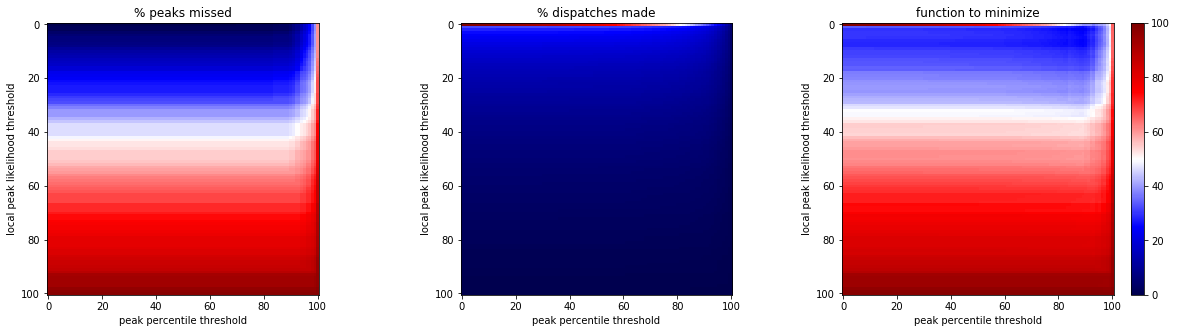

In [319]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(21, 5))
n = np.array(and_true_p)
img = axes[0].imshow(n, cmap=(plt.cm.seismic), interpolation='nearest', vmin=0, vmax=100)
axes[0].set_title('% peaks missed')


n = np.array(and_true_d)
axes[1].imshow(n, cmap=plt.cm.seismic, interpolation='nearest', vmin=0, vmax=100)
axes[1].set_title('% dispatches made')

n = np.array(and_true_f)
img = axes[2].imshow(n, cmap=plt.cm.seismic, interpolation='nearest', vmin=0, vmax=100)
axes[2].set_title('function to minimize')

for i in range(3):
    axes[i].set_xlabel('peak percentile threshold')
    axes[i].set_ylabel('local peak likelihood threshold')

fig.colorbar(img)
plt.savefig(REGION + '.png', dpi=150)

In [320]:
n = np.array(and_true_f)
min_args = np.unravel_index(n.argmin(), n.shape)
print(min_args)
test(df, *min_args, use_and=True)

(2, 89)


{'percent_dispatched': 21.04,
 'percent_peaks_missed': 2.5,
 'minimize_function': 23.54}

In [321]:
n = np.array(and_false_f)
min_args = np.unravel_index(n.argmin(), n.shape)
print(min_args)
test(df, *min_args, use_and=False)

(7, 100)


{'percent_dispatched': 22.27,
 'percent_peaks_missed': 7.5,
 'minimize_function': 29.77}